<a href="https://colab.research.google.com/github/Bikash0122/RUL-Prediction-Project/blob/main/RUL_turbofan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
import zipfile
import os

# --- : Uploading, Unziping, and Loading the Data  ---

# Uploading the file from the computer
print("Please upload the 'CMAPSSData.zip' file.")
uploaded = files.upload()

try:
    #  Unziping the file
    zip_file_name = list(uploaded.keys())[0]
    print(f"\nUnzipping '{zip_file_name}'...")
    with zipfile.ZipFile(zip_file_name, "r") as zip_ref:
        zip_ref.extractall()
    print("Unzipping complete.")

    #  Loading the training data from the unzipped file
    file_path = 'train_FD001.txt' # The file should now be in the main directory
    column_names = ['unit_number', 'time_in_cycles', 'setting_1', 'setting_2', 'setting_3']
    column_names.extend([f'sensor_{i}' for i in range(1, 22)])

    df_train = pd.read_csv(file_path, sep=r'\s+', header=None, names=column_names)

    print("\nSuccess! Data loaded correctly. Here are the first 5 rows:")
    display(df_train.head())

except Exception as e:
    print(f"An error occurred. Please try running this cell again. Error: {e}")

Please upload the 'CMAPSSData.zip' file.


Saving CMAPSSData.zip to CMAPSSData (2).zip

Unzipping 'CMAPSSData (2).zip'...
Unzipping complete.

Success! Data loaded correctly. Here are the first 5 rows:


,unit_number,time_in_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Creating Plot 1: Distribution of Engine Lifetimes...


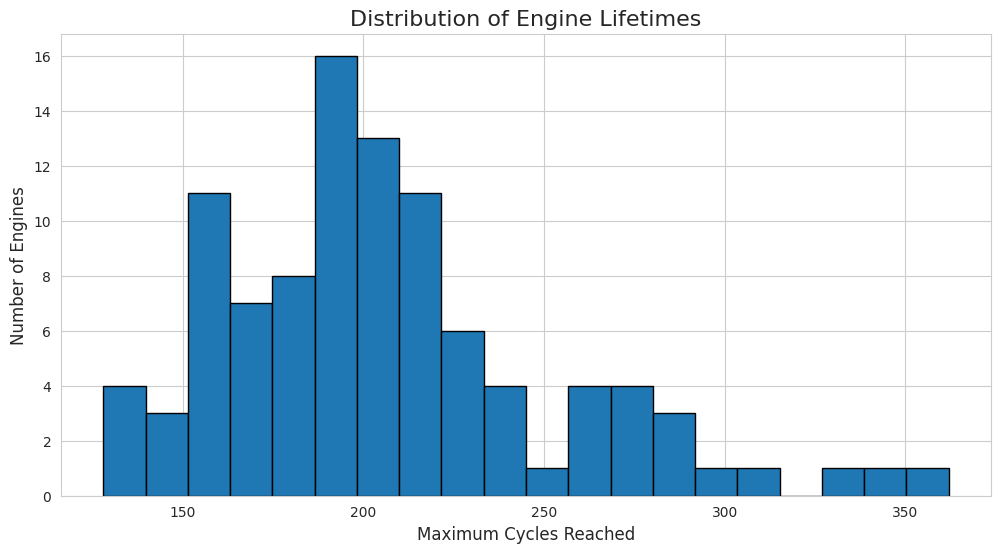


Creating Plot 2: Sensor Trends for Engine 1...


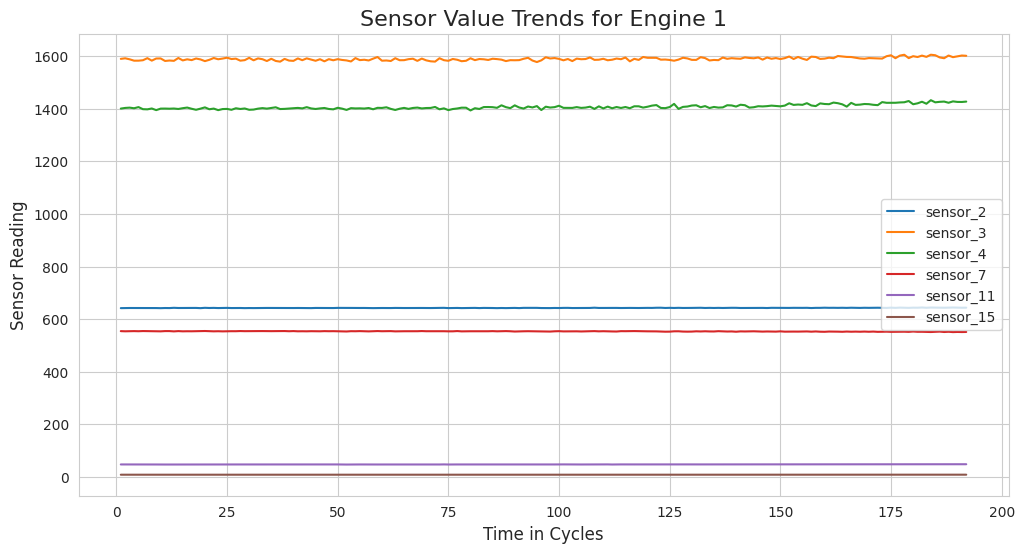

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style('whitegrid')


print("Creating Plot 1: Distribution of Engine Lifetimes...")
plt.figure(figsize=(12, 6))
engine_lifetimes = df_train.groupby('unit_number')['time_in_cycles'].max()
plt.hist(engine_lifetimes, bins=20, edgecolor='black')
plt.title('Distribution of Engine Lifetimes', fontsize=16)
plt.xlabel('Maximum Cycles Reached', fontsize=12)
plt.ylabel('Number of Engines', fontsize=12)
plt.show()


print("\nCreating Plot 2: Sensor Trends for Engine 1...")
plt.figure(figsize=(12, 6))
engine_1_data = df_train[df_train['unit_number'] == 1]
sensors_to_plot = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_11', 'sensor_15']

for sensor in sensors_to_plot:
    plt.plot(engine_1_data['time_in_cycles'], engine_1_data[sensor], label=sensor)

plt.title('Sensor Value Trends for Engine 1', fontsize=16)
plt.xlabel('Time in Cycles', fontsize=12)
plt.ylabel('Sensor Reading', fontsize=12)
plt.legend()
plt.show()

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ---  Calculating and Cliping RUL ---
print("Running Step 3: Calculating and Clipping RUL...")
max_cycles_df = df_train.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycles_df.columns = ['unit_number', 'max_cycles']
df_train = pd.merge(df_train, max_cycles_df, on='unit_number', how='left')
df_train['RUL'] = df_train['max_cycles'] - df_train['time_in_cycles']
df_train = df_train.drop(columns=['max_cycles'])

# Capping the maximum RUL value at 125.
df_train['RUL'] = df_train['RUL'].clip(upper=125)
print("Step 3 Complete.")


# ---  Feature Engineering ---
print("\nRunning Step 4: Engineering rolling features...")
window_size = 5
sensor_cols = [f'sensor_{i}' for i in range(1, 22)]
for col in sensor_cols:
    df_train[f'{col}_avg'] = df_train.groupby('unit_number')[col].rolling(window=window_size, min_periods=1).mean().reset_index(level=0, drop=True)
    df_train[f'{col}_std'] = df_train.groupby('unit_number')[col].rolling(window=window_size, min_periods=1).std().reset_index(level=0, drop=True)
print("Step 4 Complete.")


# ---  Clean, Prepare, and Train the Model ---
print("\nRunning Step 5: Cleaning, preparing, and training the model...")


df_train.dropna(inplace=True)

# Selecting only the sensors that show clear degradation trends
good_sensors = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_11',
                'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']
feature_cols = good_sensors + [f'{s}_avg' for s in good_sensors] + [f'{s}_std' for s in good_sensors]

X = df_train[feature_cols]
y = df_train['RUL']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Data split complete. Training on {len(X_train)} samples, testing on {len(X_test)} samples.")

# Creating and training the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("Training the Random Forest model...")
rf_model.fit(X_train, y_train)
print("Training complete.")

# Evaluating the final model
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n--- FINAL CORRECTED MODEL EVALUATION RESULTS ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")
print("------------------------------------------------")

Running Step 3: Calculating and Clipping RUL...
Step 3 Complete.

Running Step 4: Engineering rolling features...
Step 4 Complete.

Running Step 5: Cleaning, preparing, and training the model...
Data split complete. Training on 16344 samples, testing on 4087 samples.
Training the Random Forest model...
Training complete.

--- FINAL CORRECTED MODEL EVALUATION RESULTS ---
Root Mean Squared Error (RMSE): 15.88
R-squared (R2) Score: 0.85
------------------------------------------------
